In [42]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops
import os
import random
import pandas as pd
import numpy as np
%matplotlib inline
np.random.seed(1)

In [50]:
train_dir='train_set/'
val_dir='val_set/'
train_df=pd.read_csv('train_labels.csv')
train_df['path']=train_df['img_name'].map(lambda x: os.path.join(train_dir,x))
randomList = random.sample(range(0, 110000, 10),10000 )
randomList.sort()
train_df=train_df.loc[randomList,:]
train_df=train_df.reset_index(drop=True)


In [51]:
data=[]
os.chdir('train_set')
for i in range(len(train_df)):
    path=train_df['img_name'][i]
    img=Image.open(path)
    img=img.resize((400,400))
    img=img.convert('RGB')
    im=np.asarray(img)
    data.append(im)

arr=np.array(data)   
X_train=arr
X_train=X_train/255
Y_train=np.asarray(train_df['label'])
Y_train=Y_train.reshape(-1,1)
Y_train=Y_train.T

def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y
Y_train=convert_to_one_hot(Y_train,251)
Y_train=Y_train.T


In [52]:
os.chdir('..')
train_dir='train_set/'
test_df=pd.read_csv('test_labels.csv')
test_df['path']=test_df['img_name'].map(lambda x: os.path.join(train_dir,x))
data=[]
os.chdir('train_set')
for i in range(len(test_df)):
    path=test_df['img_name'][i]
    img=Image.open(path)
    img=img.resize((400,400))
    img=img.convert('RGB')
    im=np.asarray(img)
    data.append(im)

arr=np.array(data)   
X_test=arr
X_test=X_test/255
Y_test=np.asarray(test_df['label'])
Y_test=Y_test.reshape(-1,1)
Y_test=Y_test.T
Y_test=convert_to_one_hot(Y_test,251)
Y_test=Y_test.T

In [53]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):

    X = tf.placeholder(dtype=np.float32,shape=[None, n_H0, n_W0, n_C0])
    Y = tf.placeholder(dtype=np.float32,shape=[None,n_y])
    return X, Y

In [54]:

def initialize_parameters():

    
    tf.set_random_seed(1)                             
        
    W1 = tf.get_variable("W1",[4,4,3,8],initializer= tf.contrib.layers.xavier_initializer(seed = 0))
    W2 = tf.get_variable("W2",[2,2,8,16],initializer= tf.contrib.layers.xavier_initializer(seed = 0))
  

    parameters = {"W1": W1,
                  "W2": W2}
    
    return parameters

In [55]:
def forward_propagation(X, parameters):
   
    
    W1 = parameters['W1']
    W2 = parameters['W2']
    
   
    Z1 = tf.nn.conv2d(X,W1,strides=[1,1,1,1],padding="SAME")
    
    A1 = tf.nn.relu(Z1)
    
    P1 = tf.nn.max_pool(A1,ksize=[1,8,8,1],strides=[1,8,8,1],padding = "SAME")
    
    Z2 = tf.nn.conv2d(P1,W2,strides=[1,1,1,1],padding="SAME")
    # RELU
    A2 = tf.nn.relu(Z2)
    
    P2 = tf.nn.max_pool(A2,ksize=[1,4,4,1],strides=[1,4,4,1],padding="SAME")
    
    F = tf.contrib.layers.flatten(P2)
    
    Z3 = tf.contrib.layers.fully_connected(F,251,activation_fn=None)
    

    return Z3

In [56]:

def compute_cost(Z3, Y):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Z3,labels=Y))
    return cost

In [57]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    
    
    m = X.shape[0]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,:,:,:]
    shuffled_Y = Y[permutation,:]

    
    num_complete_minibatches = math.floor(m/mini_batch_size) 
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:,:,:]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m,:,:,:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [58]:


def predict(X, parameters):
    
    W1 = tf.convert_to_tensor(parameters["W1"])
    b1 = tf.convert_to_tensor(parameters["b1"])
    W2 = tf.convert_to_tensor(parameters["W2"])
    b2 = tf.convert_to_tensor(parameters["b2"])
    W3 = tf.convert_to_tensor(parameters["W3"])
    b3 = tf.convert_to_tensor(parameters["b3"])
    
    params = {"W1": W1,
              "b1": b1,
              "W2": W2,
              "b2": b2,
              "W3": W3,
              "b3": b3}
    
    x = tf.placeholder("float", [480000, 1])
    
    z3 = forward_propagation_for_predict(x, params)
    p = tf.argmax(z3)
    
    sess = tf.Session()
    prediction = sess.run(p, feed_dict = {x: X})
        
    return prediction

In [59]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.009,
          num_epochs = 100, minibatch_size = 64, print_cost = True):
 
    
    ops.reset_default_graph()                         
    tf.set_random_seed(1)                             
    seed = 3                                          
    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = []                                        
  
    X, Y = create_placeholders(n_H0,n_W0,n_C0,n_y)
   
    parameters = initialize_parameters()
  
    Z3 = forward_propagation(X,parameters)
    cost = compute_cost(Z3,Y)
    
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss=cost)
    
    init = tf.global_variables_initializer()
     
    
    with tf.Session() as sess:
        
       
        sess.run(init)
        
        
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size) 
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
               
                
                _ , temp_cost = sess.run(fetches=[optimizer,cost],feed_dict={X:minibatch_X, Y:minibatch_Y})
               
                
                minibatch_cost += temp_cost / num_minibatches
                

            # Print the cost every epoch
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
        
        
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # Calculate the correct predictions
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
                
        return train_accuracy, test_accuracy, parameters
    

Cost after epoch 0: 6.612280
Cost after epoch 5: 2.602188
Cost after epoch 10: 0.125391
Cost after epoch 15: 0.009294
Cost after epoch 20: 0.004989
Cost after epoch 25: 0.000716
Cost after epoch 30: 0.000447
Cost after epoch 35: 0.000350
Cost after epoch 40: 0.000281
Cost after epoch 45: 0.000238
Cost after epoch 50: 0.000203
Cost after epoch 55: 0.000170
Cost after epoch 60: 0.000148
Cost after epoch 65: 0.000131
Cost after epoch 70: 0.000118
Cost after epoch 75: 0.000106
Cost after epoch 80: 0.000095
Cost after epoch 85: 0.000086
Cost after epoch 90: 0.000079
Cost after epoch 95: 0.000072


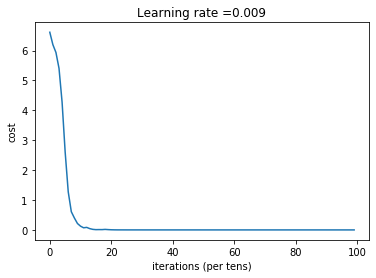

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 1.0
Test Accuracy: 0.033333335


In [60]:
_, _, parameters = model(X_train, Y_train, X_test, Y_test)